# **ADM Homework 5 - USA Airport Flight Analysis**

### Import Dataset and Libraries

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download flashgordon/usa-airport-dataset

In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

We unzip the file downloaded from Kaggle and save it to our current working directory.

In [5]:
# Unzip the file we downloaded from kaggle
zip_file_path = 'usa-airport-dataset.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.') # extract files to current working directory

Now we save the data in a CSV file:

In [2]:
df = pd.read_csv('Airports2.csv')
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


### Data Cleaning

According to the source website https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset, this dataset (with data from the OpenFlights website) contains over 3.5 million US Domestic Flights from 1990 to 2009.

It contains the following features:

1. `Origin_airport`: Three letter airport code of the origin airport  
2. `Destination_airport`: Three letter airport code of the destination airport  
3. `Origin_city`: Origin city name  
4. `Destination_city`: Destination city name  
5. `Passengers`: Number of passengers transported from origin to destination  
6. `Seats`: Number of seats available on flights from origin to destination  
7. `Flights`: Number of flights between origin and destination (multiple records for one month, many with flights > 1)  
8. `Distance`: Distance (to nearest mile) flown between origin and destination  
9. `Fly_date`: The date (yyyymm) of flight  
10. `Origin_population`: Origin city's population as reported by US Census  
11. `Destination_population`: Destination city's population as reported by US Census  
12. `Org_airport_lat`: latitude of the origin airport  
13. `Org_airport_long`: longitude of the origin airport  
14. `Dest_airport_lat`: latitude of the destination airport  
15. `Dest_airport_long`: longitude of the destination airport

Here we can see the shape of the dataset:

In [3]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns {df.shape[1]}')

Number of rows: 3606803
Number of columns 15


Now we look for missing values:

In [4]:
# Look for missing values
missing_counts = df.isnull().sum()
missing_counts

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

The most important features have no missing values, and the missing rows in the latitude and longitude columns can be dealt with later if it is needed, for example by looking up these values for the corresponding airports.

Next, we do a data type integrity check. `Passengers`, `Seats`, `Flights`, `Origin_population`, `Destination_population` should be integers, `Distance` and the coordinates columns should be numeric (float or integer), and `Fly_date` should be in date format.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


All data types seem correct, but it would be good to convert the `Fly_date` column type from object to datetime. From the output above it seems that the column is in the yyyy-dd-mm format. We can verify if the second or third number in the date is above 12 somewhere, to make sure the third number actually indicates the month:

In [6]:
# Check if day>12 or month>12 somewhere to figure out date format
for date in df['Fly_date']:
    year, entry2, entry3 = map(int, date.split('-'))
    if entry2>12:
        print('Format is yyyy-dd-mm')
    if entry3>13:
        print('Format is yyyy-mm-dd')

# See if the third date entry is different from '01' somewhere
for date in df['Fly_date']:
    year, entry2, entry3 = map(str, date.split('-'))
    if entry3 != '01':
        print(date)

Since neither the second nor third entry in the date contain values above 13, the format remains ambiguous. We will treat the format in the column as yyyy-dd-mm because the last number is consistently '01', and thus convert it to datetime:

In [7]:
df['Fly_date'] =pd.to_datetime(df['Fly_date'], format='%Y-%d-%m')

We can verify if there are any duplicates, and if there are, create a copy of the dataset without duplicate rows. Since there are no timestamp values, it could be that duplicate rows are due to the existence of multiple flights in the same day with the exact same information. For this reason, we will keep the original dataset with all the rows too.

In [8]:
# Count number of duplicates
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

# Save a copy of the dataset without the duplicates
df2 = df.drop_duplicates()
print(f'Number of rows after removing duplicates: {df2.shape[0]}')

Number of duplicate rows: 41753
Number of rows after removing duplicates: 3565050


Now we check if the latitude and longitude data is valid. Latitude values, if not missing, should be in the interval [-90,90], and longitude values in the interval [-180, 180].

In [9]:
# Check if not missing latitude values are in [-90, 90]
print(f' Mininum latitude: {df['Org_airport_lat'].min()}, Maximum latitude: {df['Org_airport_lat'].max()}')

# Check if not missing longitude values are in [-180, 180]
print(f' Mininum longitude: {df['Org_airport_long'].min()}, Maximum longitude: {df['Org_airport_long'].max()}')

 Mininum latitude: 19.721399307251, Maximum latitude: 64.83750153
 Mininum longitude: -157.921997070312, Maximum longitude: -68.8281021118164


Additionally, we would like the number of passengers to not exceed the number of seats:

In [10]:
# Check if number of passangers is greater than number of seats
print(f'Number of rows for which number of passengers is greater than number of seats: {df[df['Passengers']>df['Seats']].shape[0]}')

Number of rows for which number of passengers is greater than number of seats: 280


There are 280 flights with more passengers than seats, which is a problematic that can happen if there is overbooking. Sometimes, airlines might sell more tickets than there are seats because there could be passangers that cancel or do not show up.

Lastly, we want to make sure that the same airport code is not associated with different cities:

In [33]:
# Group by 'Destination_airport' and count unique values of 'Destination_city' (we want all 1s)
dest_max__num_cities_for_code = max(df2.groupby('Destination_airport')['Destination_city'].nunique())
print(f'Maximum number of cities associated with a destination airport code: {dest_max__num_cities_for_code}')

# Group by 'Origin_airport' and count unique values of 'Origin_city' (we want all 1s)
origin_max__num_cities_for_code = max(df2.groupby('Origin_airport')['Origin_city'].nunique())
print(f'Maximum number of cities associated with an origin airport code: {origin_max__num_cities_for_code}')

Maximum number of cities associated with a destination airport code: 1
Maximum number of cities associated with an origin airport code: 1


Perfect, every airport code only has one associated city.

### Create the Graph

To work with the airline graph, we will create a directed graph class:

In [23]:
# Custom DiGraph Class
class CustomDiGraph:
    def __init__(self):
        '''Initialization of an empty graph'''
        self.nodes = set()  # set to store nodes
        self.edges = defaultdict(set) # default dictionary to store edges: key=node, value=set of neighbors

    def add_node(self, node):
        '''Function to add a node to the graph'''
        self.nodes.add(node)

    def add_edge(self, node1, node2):
        '''Function that adds an outgoing edge from node1 to node2'''
        # Add node1 and node2 to set of nodes in case they are not already in it
        self.add_node(node1)
        self.add_node(node2)
        self.edges[node1].add(node2) # add node2 to set of neighbors of node1

    def remove_node(self, node):
        '''Function that removes a node and all edges connected to it'''
        if node in self.nodes:
            self.nodes.remove(node)
            del self.edges[node]  # Remove the node from the edges dictionary
            # Remove any edges that point to this node
            for other_node in list(self.edges.keys()):
                self.edges[other_node].discard(node)

    def remove_edge(self, node1, node2):
        '''Function that removes an edge from node1 to node2'''
        self.edges[node1].discard(node2)

    def remove_all_edges(self, node1, node2):
        '''Function that removes any edge between node1 and node2'''
        self.edges[node1].discard(node2)
        self.edges[node2].discard(node1)
    
    def get_neighbors(self, node):
        '''Function that returns the neighbors of a node'''
        return self.edges[node]

    def get_nodes(self):
        '''Function that returns a list of all nodes'''
        return list(self.nodes)

    def get_edges(self):
        '''Function that returns a set of all edges as tuples (node1, node2)'''
        edge_set = set()
        for node1 in self.nodes:
            for node2 in self.get_neighbors(node1):
                edge_set.add((node1, node2))
        return edge_set
    
    def has_edge(self, node1, node2):
        '''Function that returns True if there is an edge between node1 and node2'''
        return node2 in self.get_neighbors(node1)

    def out_degree(self, node):
        '''Returns the out-degree of a node (number of outgoing edges)'''
        if node in self.edges:
            return len(self.edges[node])
        else:
            return 0
    
    def in_degree(self, node):
        '''Returns the in-degree of a node (number of incoming edges)'''
        num_in_edges = 0
        for neighbor in self.nodes:
            if node in self.edges[neighbor]:
                num_in_edges += 1
        return num_in_edges

    def __str__(self):
        '''Function that returns a string representation of the graph'''
        return f'Nodes: {self.nodes}\nEdges: {self.get_edges()}'
    
    def to_networkx_digraph(self):
        '''Function that converts the custom graph to a NetworkX DiGraph'''
        G = nx.DiGraph()
        for node in self.nodes:
            G.add_node(node)
        for node1, neighbors in self.edges.items():
            for node2 in neighbors:
                G.add_edge(node1, node2)
        return G
    
    def num_nodes(self):
        '''Function that returns the number of nodes in the graph'''
        return len(self.nodes)
    
    def num_edges(self):
        '''Function that returns the number of edges in the graph'''
        return len(self.get_edges())

In [14]:
# Custom Undirected Graph Class

from collections import defaultdict
import networkx as nx

class CustomGraph:
    def __init__(self):
        '''Initialization of an empty graph'''
        self.nodes = set()  # set to store nodes
        self.edges = defaultdict(set)  # default dictionary to store edges: key=node, value=set of neighbors

    def add_node(self, node):
        '''Function to add a node to the graph'''
        self.nodes.add(node)

    def add_edge(self, node1, node2):
        '''Function that adds an edge between node1 and node2'''
        self.add_node(node1)
        self.add_node(node2)
        self.edges[node1].add(node2)
        self.edges[node2].add(node1)

    def remove_node(self, node):
        '''Function that removes a node and all edges connected to it'''
        if node in self.nodes:
            self.nodes.remove(node)
            del self.edges[node]
            for other_node in list(self.edges.keys()):
                self.edges[other_node].discard(node)

    def remove_edge(self, node1, node2):
        '''Function that removes edge between node1 and node2'''
        self.edges[node1].discard(node2)
        self.edges[node2].discard(node1)

    def get_neighbors(self, node):
        '''Function that returns the neighbors of a node'''
        return self.edges[node]

    def get_nodes(self):
        '''Function that returns a list of all nodes'''
        return list(self.nodes)

    def get_edges(self):
        '''Function that returns a set of all edges as tuples (node1, node2)'''
        edge_set = set()
        for node1 in self.nodes:
            for node2 in self.get_neighbors(node1):
                if (node2, node1) not in edge_set:
                    edge_set.add((node1, node2))
        return edge_set

    def has_edge(self, node1, node2):
        '''Function that returns True if there is an edge between node1 and node2'''
        return node2 in self.get_neighbors(node1)

    def degree(self, node):
        '''Returns the degree of a node (number of edges connected to it)'''
        if node in self.edges:
            return len(self.edges[node])
        else:
            return 0
        
    def __str__(self):
        '''Function that returns a string representation of the graph'''
        return f'Nodes: {self.nodes}\nEdges: {self.get_edges()}'

    def to_networkx_graph(self):
        '''Function that converts the custom graph to a NetworkX Graph'''
        G = nx.Graph()
        for node in self.nodes:
            G.add_node(node)
        for node1, neighbors in self.edges.items():
            for node2 in neighbors:
                G.add_edge(node1, node2)
        return G

    def num_nodes(self):
        '''Function that returns the number of nodes in the graph'''
        return len(self.nodes)

    def num_edges(self):
        '''Function that returns the number of edges in the graph'''
        return len(self.get_edges())


Now we initialize the `flight_network` graph, add nodes to it for each airport, and directed edges for flights (from origin airport to destination airport).

In [24]:
flight_network = CustomDiGraph()

In [25]:
# Add all unique airports (origin and destination) as nodes
all_airports = set(df['Origin_airport']).union(set(df['Destination_airport']))
for airport in all_airports:
    flight_network.add_node(airport)

# Add edges to the graph
for idx in range(df2.shape[0]):
    origin = df2['Origin_airport'].iloc[idx]
    destination = df2['Destination_airport'].iloc[idx]
    # If the edge is not there yet, add the edge
    if not flight_network.has_edge(origin, destination):
        flight_network.add_edge(origin, destination)

Here we plot the graph of the USA airports network by using the networkx library (just for visualization purposes). To prevent the graph from being too messy, we did not add labels here.

Text(0.5, 1.0, 'USA Airports Network')

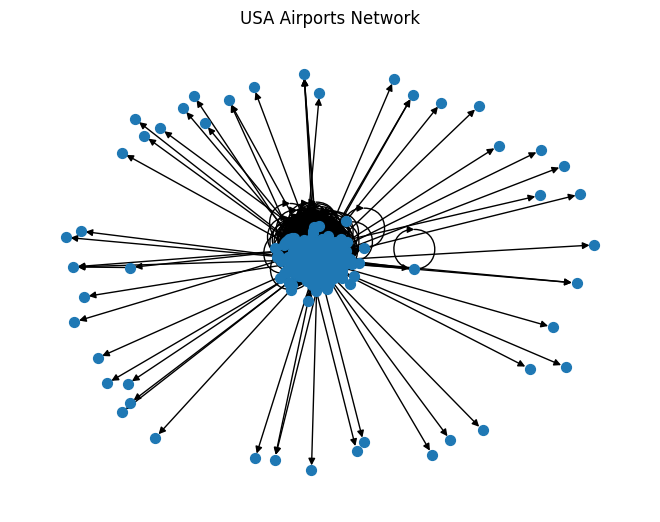

In [26]:
# Plot the graph using NetworkX
G = flight_network.to_networkx_digraph()
nx.draw(G, node_size=50)
plt.title('USA Airports Network')

Here we can check how many of the edges are reciprocated, to see if using a directed graph instead of an undirected graph was the right choice:

In [21]:
# Calculate the number of reciprocated edges
reciprocated_edges = 0
for edge in G.edges():
    # Check if the reverse edge exists (reciprocated)
    if G.has_edge(edge[1], edge[0]):
        reciprocated_edges += 1

# Calculate the percentage of reciprocated edges
if len(G.edges())>0:
    percentage_reciprocated_edges = reciprocated_edges / len(G.edges())*100
    print(f'Percentage of reciprocated edges: {percentage_reciprocated_edges:.2f}%')
else:
    print('No edges in the graph.')

Percentage of reciprocated edges: 74.04%


About 74.04% of the edges are reciprocated, so some nodes only have one-way connections, which is best represented by a directed graph.

### Implement the function ```analyze_graph_features(flight_network)```

Now we implement a function `analyze_graph_features(flight_network)` that takes the `flight_network` as input and computes:

* Number of airports (nodes) and flights (edges) in the graph.
* Density of the (directed) graph: $\frac{E}{n \cdot (n-1)}$
* Calculate in-degree and out-degree values for each airport and visualize them using histograms
* Find airports with degrees higher than the 90th percentile and list them as *hubs*
* Determine if the graph is sparse or dense based on its density

In [38]:
def analyze_graph_features(flight_network):
    # Count number of airports (nodes)
    num_airports = flight_network.num_nodes()

    # Count number of flights (edges)
    num_flights = flight_network.num_edges()

    # Calculate density
    density = num_flights / (num_airports*(num_airports-1))

    # Calculate in-degrees
    in_degrees = [flight_network.in_degree(node) for node in flight_network.get_nodes()]

    # Calculate out-degrees
    out_degrees = [flight_network.out_degree(node) for node in flight_network.get_nodes()]

    # Plot histograms of in-degrees and out-degrees
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=30)
    plt.xlabel('In-degree')
    plt.ylabel('Frequency')
    plt.title('In-degree Distribution')
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=30)
    plt.xlabel('Out-degree')
    plt.ylabel('Frequency')
    plt.title('Out-degree Distribution')
    plt.tight_layout()

    # Calculate 90th percentile of in_degrees
    percentile_90_in_degrees = np.percentile(in_degrees, 90)

    # Calculate 90th percentile of out_degrees
    percentile_90_out_degrees = np.percentile(out_degrees, 90)

    # Find airports with in-degree greater than 90th percentile
    in_degree_hubs = [node for node in flight_network.get_nodes() if flight_network.in_degree(node) > percentile_90_in_degrees]
    out_degree_hubs = [node for node in flight_network.get_nodes() if flight_network.out_degree(node) > percentile_90_out_degrees]

    # Determine hubs as airports with high in-degree or out-degree
    hubs = list(set(in_degree_hubs).union(set(out_degree_hubs)))

    # Determine if the graph is dense or sparse based on the density
    threshold = 0.05
    dense = False
    if density > threshold:
        dense = True

    print(f'Number of airports (nodes): {num_airports}')
    print(f'Number of flights (edges): {num_flights}')
    print(f'Graph Density: {density}')
    print(f'Graph is dense: {dense}')
    print('Hubs:')
    print(hubs)
    print('Degree distributions: ')
    plt.show()

    return num_airports, num_flights, density, hubs

We apply the `analyze_graph_features` function to analyze the graph:

Number of airports (nodes): 727
Number of flights (edges): 36719
Graph Density: 0.0695696492245198
Graph is dense: True
Hubs:
['SAT', 'SYR', 'COS', 'SAN', 'ELP', 'LAX', 'FLL', 'CAE', 'YIP', 'OAK', 'GSP', 'MSP', 'DSM', 'ORD', 'DFW', 'MDW', 'MKE', 'LRD', 'OMA', 'BHM', 'HOU', 'TPA', 'GRR', 'SFO', 'AUS', 'BNA', 'LAS', 'STL', 'BWI', 'RDU', 'PIA', 'BUF', 'IAH', 'MCI', 'LGA', 'ICT', 'ATL', 'IAD', 'SBN', 'OKC', 'CLT', 'LIT', 'PHX', 'DAY', 'SLC', 'CVG', 'CMH', 'TUL', 'LEX', 'MEM', 'PIT', 'ABQ', 'BOS', 'JAX', 'PDX', 'IND', 'FWA', 'CLE', 'DTW', 'SEA', 'TOL', 'LAN', 'GSO', 'MSN', 'EWR', 'MSY', 'MCO', 'BDL', 'RFD', 'MIA', 'TUS', 'RNO', 'JFK', 'SHV', 'PHL', 'CHA', 'TYS', 'DAL']
Degree distributions: 


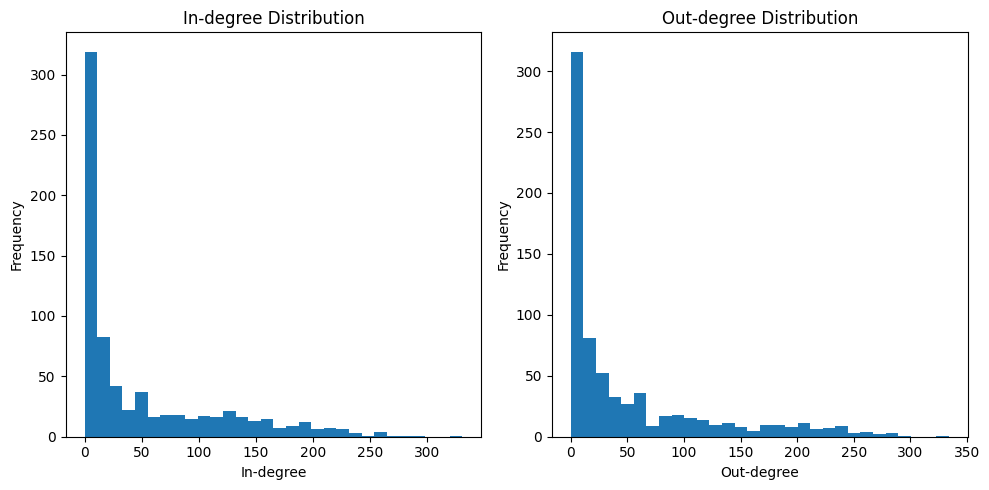

In [39]:
num_airports, num_flights, density, hubs = analyze_graph_features(flight_network)

This analysis shows hubs by their airport code. To get a list of cities where the hubs are located, we can implement a dictionary that maps airport codes to their city, then apply it to the list of hub airport codes.

In [37]:
# Dictionary that maps codes to cities
code_to_city_dict = defaultdict(str)

# Populate code_to_city_dict
for idx in range(df2.shape[0]):
    # Origin code and city of the row
    origin_code = df2['Origin_airport'].iloc[idx]
    origin_city = df2['Origin_city'].iloc[idx]
    # Destination code and city of the row
    destination_code = df2['Destination_airport'].iloc[idx]
    destination_city = df2['Destination_city'].iloc[idx]
    # Add values to dictionary (if not already present)
    if origin_code not in code_to_city_dict.keys():
        code_to_city_dict[origin_code] = origin_city
    if destination_code not in code_to_city_dict.keys():
        code_to_city_dict[destination_code] = destination_city

Here are the cities of the hubs:

In [40]:
# List of cities with hubs
hubs_cities = [code_to_city_dict[hub] for hub in hubs]

# Display these cities in a DataFrame
hubs_cities_df = pd.DataFrame(hubs_cities, columns=['Hubs Cities'])
display(hubs_cities_df)

,Hubs Cities
0,"San Antonio, TX"
1,"Syracuse, NY"
2,"Colorado Springs, CO"
3,"San Diego, CA"
4,"El Paso, TX"
...,...
73,"Shreveport, LA"
74,"Philadelphia, PA"
75,"Chattanooga, TN"
76,"Knoxville, TN"


### Implement the function ```summarize_graph_features(flight_network)```

### Graph Analysis

### Report

### Questions